<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Interpreting Heterogeneous Effect Models with SHAP

[SHAP](https://shap.readthedocs.io/en/latest/) is a popular open source library for interpreting black-box machine learning models using the [Shapley values methodology](https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html).

Similar to how black-box predictive machine learning models can be explained with SHAP, we can also explain black-box effect heterogeneity models. This approach provides an explanation as to why a heterogeneous causal effect model produced larger or smaller effect values for particular segments of the population. Which were the features that lead to such differentiation? This question is easy to address when the model is succinctly described, such as the case of linear heterogneity models, where one can simply investigate the coefficients of the model. However, it becomes hard when one starts using more expressive models, such as Random Forests and Causal Forests to model effect hetergoeneity. SHAP values can be of immense help to understand the leading factors of effect hetergoeneity that the model picked up from the training data.

Our package offers seamless integration with the SHAP library. Every `CateEstimator` has a method `shap_values`, which returns the SHAP value explanation of the estimators output for every treatment and outcome pair. These values can then be visualized with the plethora of visualizations that the SHAP library offers. Moreover, whenever possible our library invokes fast specialized algorithms from the SHAP library, for each type of final model, which can greatly reduce computation times.


## Notebook Contents

1. [Single Treatment - Single Outcome](#1.-Single-Treatment---Single-Outcome)
2. [Many Treatments - Many Outcomes](#2.-Many-Treatments---Many-Outcomes)

In [1]:
%load_ext lab_black

In [2]:
## Ignore warnings
from econml.dml import CausalForestDML, LinearDML, NonParamDML
from econml.dr import DRLearner
from econml.metalearners import DomainAdaptationLearner, XLearner
from econml.iv.dr import LinearIntentToTreatDRIV
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Lasso

2021-11-12 14:38:09.913487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-12 14:38:09.916223: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1. Single Treatment - Single Outcome

In [3]:
np.random.seed(123)
n_samples = 5000
n_features = 10
true_te = lambda X: (X[:, 0] > 0) * X[:, 0]
X = np.random.normal(0, 1, size=(n_samples, n_features))
W = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = true_te(X) * T + 5.0 * X[:, 0] + np.random.normal(0, 0.1, size=(n_samples,))
X_test = X[: min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(
    np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples)
)

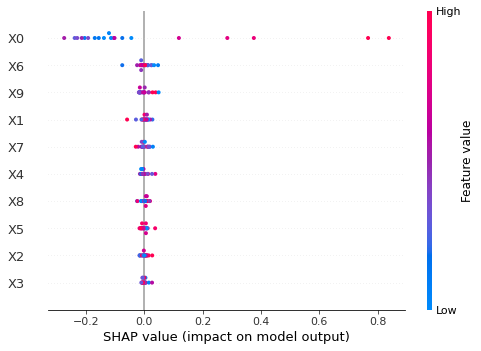

In [4]:
est = CausalForestDML(random_state=123)
est.fit(y, T, X=X, W=W)
shap_values = est.shap_values(X[:20])
shap.plots.beeswarm(shap_values["Y0"]["T0"])

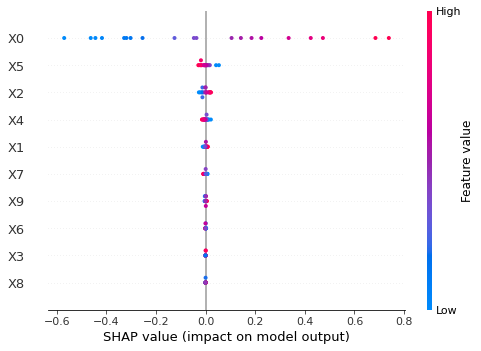

In [5]:
est = LinearDML(random_state=123)
est.fit(y, T, X=X, W=W)
shap_values = est.shap_values(X[:20])
shap.plots.beeswarm(shap_values["Y0"]["T0"])

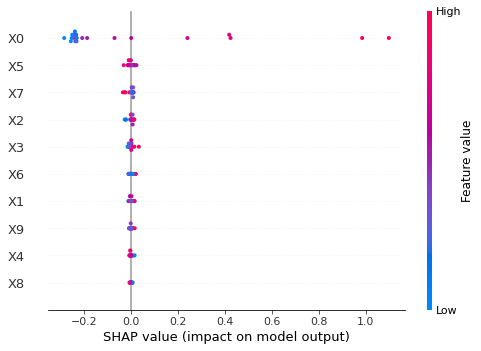

In [6]:
est = NonParamDML(
    model_y=RandomForestRegressor(min_samples_leaf=20, random_state=123),
    model_t=RandomForestRegressor(min_samples_leaf=20, random_state=123),
    model_final=RandomForestRegressor(min_samples_leaf=20, random_state=123),
    random_state=123,
)
est.fit(y.ravel(), T.ravel(), X=X, W=W)
shap_values = est.shap_values(X[:20])
shap.plots.beeswarm(shap_values["Y0"]["T0"])

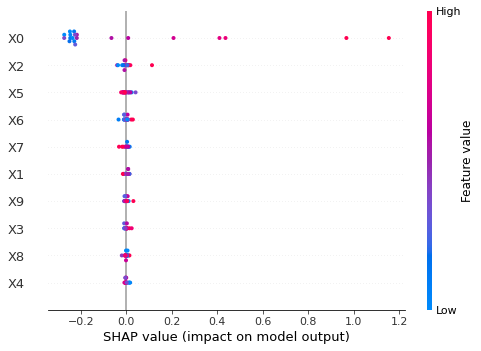

In [7]:
est = DRLearner(
    model_regression=RandomForestRegressor(min_samples_leaf=20, random_state=123),
    model_propensity=RandomForestClassifier(min_samples_leaf=20, random_state=123),
    model_final=RandomForestRegressor(min_samples_leaf=20, random_state=123),
    random_state=123,
)
est.fit(y.ravel(), T.ravel(), X=X, W=W)
shap_values = est.shap_values(X[:20])
shap.plots.beeswarm(shap_values["Y0"]["T0_1"])

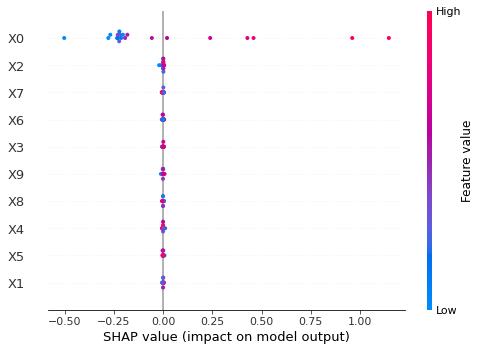

In [8]:
est = DomainAdaptationLearner(
    models=RandomForestRegressor(min_samples_leaf=20, random_state=123),
    final_models=RandomForestRegressor(min_samples_leaf=20, random_state=123),
    propensity_model=RandomForestClassifier(min_samples_leaf=20, random_state=123),
)
est.fit(y.ravel(), T.ravel(), X=X)
shap_values = est.shap_values(X[:20])
shap.plots.beeswarm(shap_values["Y0"]["T0_1"])

Exact explainer: 21it [01:03,  3.18s/it]                        


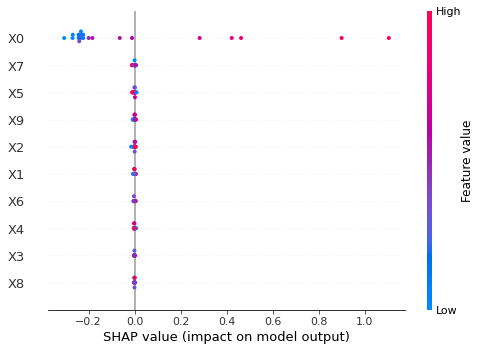

In [9]:
# Xlearner.shap_values uses a slow shap exact explainer, as there is no well defined final model
# for the XLearner method.
est = XLearner(
    models=RandomForestRegressor(min_samples_leaf=20, random_state=123),
    cate_models=RandomForestRegressor(min_samples_leaf=20, random_state=123),
    propensity_model=RandomForestClassifier(min_samples_leaf=20, random_state=123),
)
est.fit(y.ravel(), T.ravel(), X=X)
shap_values = est.shap_values(X[:20])
shap.plots.beeswarm(shap_values["Y0"]["T0_1"])

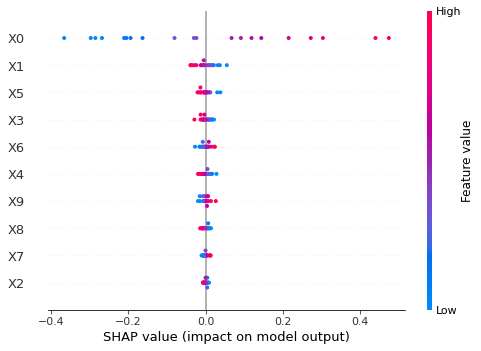

In [10]:
est = LinearIntentToTreatDRIV(
    model_y_xw=RandomForestRegressor(min_samples_leaf=20, random_state=123),
    model_t_xwz=RandomForestClassifier(min_samples_leaf=20, random_state=123),
    flexible_model_effect=RandomForestRegressor(min_samples_leaf=20, random_state=123),
    random_state=123,
)
est.fit(y.ravel(), T.ravel(), Z=T.ravel(), X=X, W=W)
shap_values = est.shap_values(X[:20])
shap.plots.beeswarm(shap_values["Y0"]["T0_1"])

# 2. Many Treatments - Many Outcomes

In [11]:
np.random.seed(123)
n_samples = 5000
n_features = 10
n_treatments = 2
n_outputs = 3
true_te = lambda X: np.hstack(
    [
        (X[:, [0]] > 0) * X[:, [0]],
        np.ones((X.shape[0], n_treatments - 1))
        * np.arange(1, n_treatments).reshape(1, -1),
    ]
)
X = np.random.normal(0, 1, size=(n_samples, n_features))
W = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = (
    np.sum(true_te(X) * T, axis=1, keepdims=True)
    + 5.0 * X[:, [0]]
    + np.random.normal(0, 0.1, size=(n_samples, 1))
)
y = np.tile(y, (1, n_outputs))
for j in range(n_outputs):
    y[:, j] = (j + 1) * y[:, j]
X_test = X[: min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(
    np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples)
)

In [12]:
est = CausalForestDML(n_estimators=400, random_state=123)
est.fit(y, T, X=X, W=W)

In [13]:
shap_values = est.shap_values(X[:200])

 98%|===================| 392/400 [00:34<00:00]        

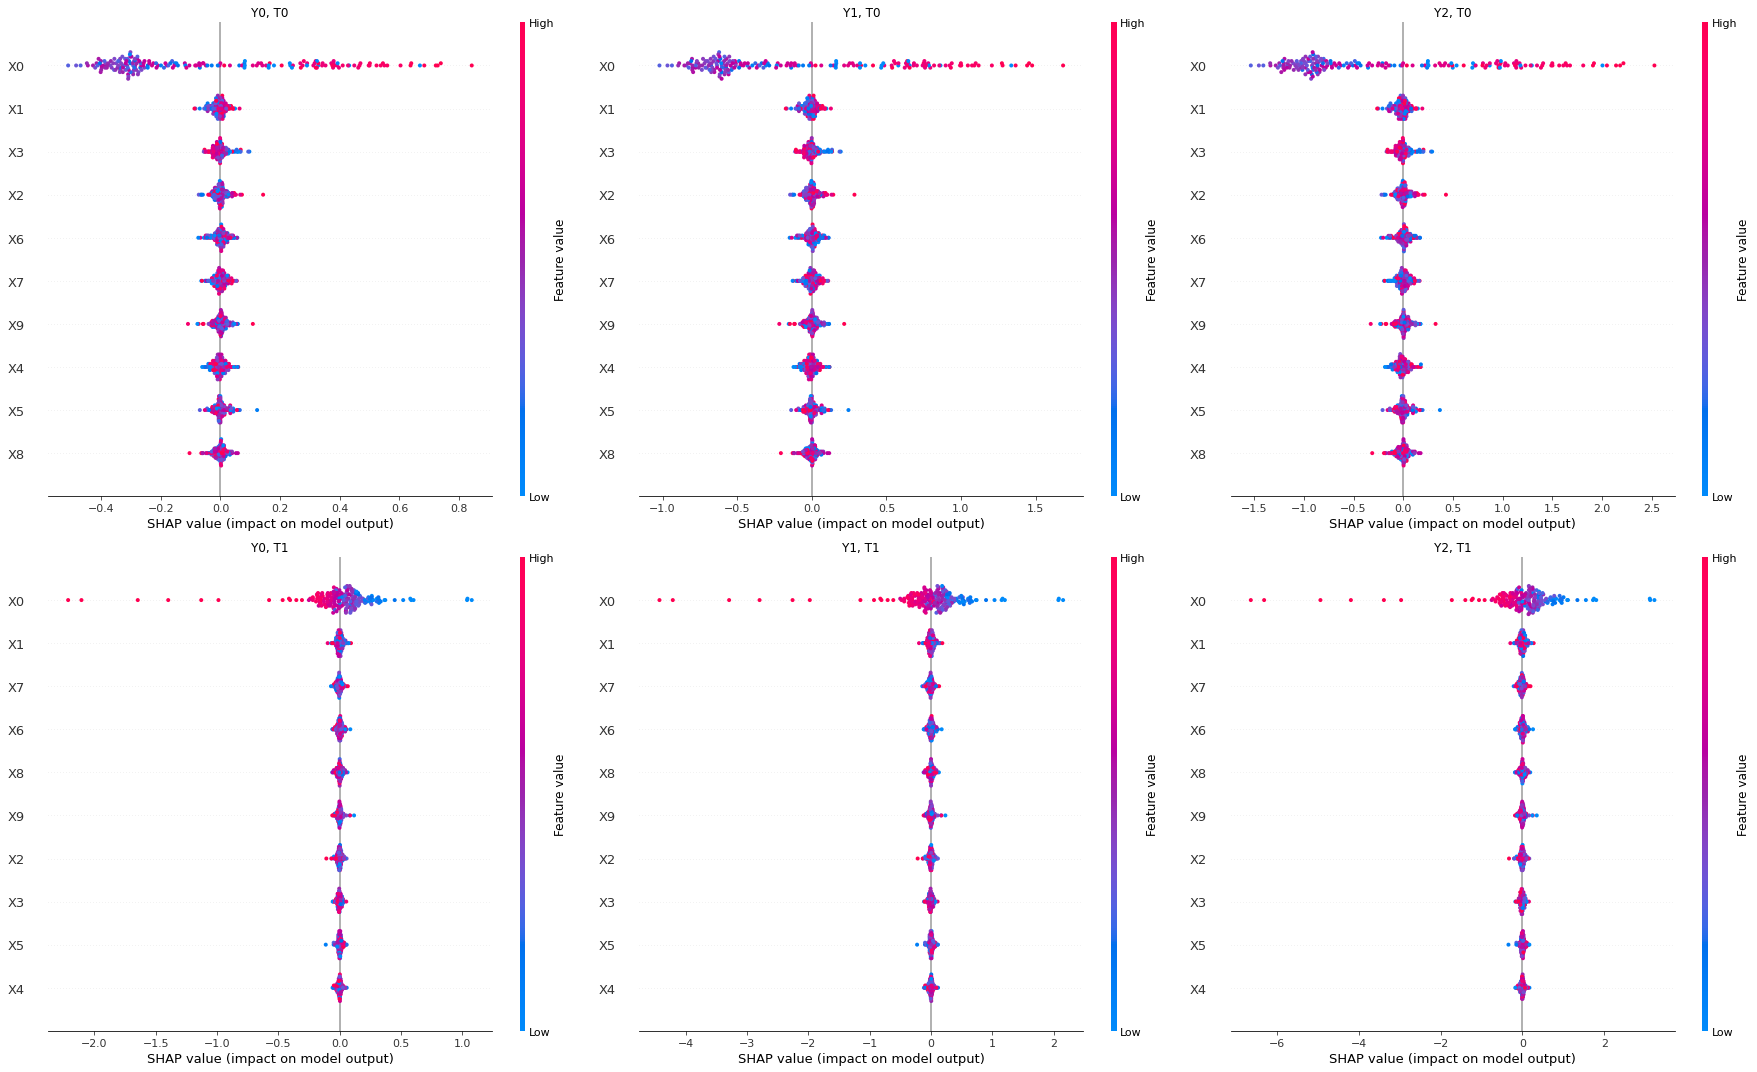

In [14]:
plt.figure(figsize=(25, 15))
for j in range(n_treatments):
    for i in range(n_outputs):
        plt.subplot(n_treatments, n_outputs, i + j * n_outputs + 1)
        plt.title("Y{}, T{}".format(i, j))
        shap.plots.beeswarm(
            shap_values["Y" + str(i)]["T" + str(j)], plot_size=None, show=False
        )
plt.tight_layout()
plt.show()